# Packages

In [1]:
# basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import quandl
import math
import re
from datetime import datetime

# normalization
from sklearn.preprocessing import StandardScaler

# statsmodel.tsa (Time series)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# sklearn (ica, train_test_split)
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split

# cmeans
import skfuzzy as fuzz

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalAveragePooling1D
from tensorflow.compat.v1.keras.layers import CuDNNLSTM # GPU version of LSTM
from tensorflow.keras.utils import to_categorical

# Functions

In [2]:
# 0. Data clear
def datelist(beginDate, endDate):
    # beginDate, endDate是形如‘20160601’的字符串或datetime格式
    date_l=[datetime.strftime(x,'%Y-%m-%d') for x in list(pd.date_range(start=beginDate, end=endDate))]
    return date_l

##############################################################################################################
def data_clear(data,start_day,end_day):
    
    data = data.loc[:,["Date","Close"]] 
    a = pd.DataFrame({"date":datelist(start_day,end_day)})
    
    df = pd.merge(a, data, left_on="date", right_on="Date" , how="left")
    
    for i in range(len(df)):
        if df.Date[i] is np.nan:
            df.Close[i] = df.Close[i-1]
            
    df = df.loc[:,["date","Close"]]
    df.columns=["Date","Price"]
    
    return df

##############################################################################################################
def data_clear_eth(data,start_day,end_day):
    
    data = data.loc[:,["Date","Close"]] 
    a = pd.DataFrame({"date":datelist(start_day,end_day)})
    
    df = pd.merge(a, data, left_on="date", right_on="Date" , how="left")
    
    for i in range(len(df)):
        if math.isnan(df.Close[i]):
            df.Close[i] = df.Close[i-1]

            
    df = df.loc[:,["date","Close"]]
    df.columns=["Date","Price"]
    
    return df

##############################################################################################################
def data_clear_ethv(data,start_day,end_day):
    
    data = data.loc[:,["Date","Volume"]] 
    a = pd.DataFrame({"date":datelist(start_day,end_day)})
    
    df = pd.merge(a, data, left_on="date", right_on="Date" , how="left")
    
    for i in range(len(df)):
        if math.isnan(df.Volume[i]):
            df.Volume[i] = df.Volume[i-1]

            
    df = df.loc[:,["date","Volume"]]
    df.columns=["Date","Volume"]
    
    return df

##############################################################################################################
def data_clear_hash(data,start_day,end_day):
    
    start = np.where(data.Date ==start_day)[0][0]
    
    try:
        end = np.where(data.Date ==end_day)[0][0]
        d_has = data.iloc[start:end+1,:]
        d_has.reset_index(drop=True,inplace=True)
    
    
    except:
        end = data.index[-1]
        d_has = data.iloc[start:end+1,:]
        d_has.reset_index(drop=True,inplace=True)
        d_has = d_has.append({"Date":end_day,"Value":d_has.iloc[-1,1]},ignore_index=True)
        
    return d_has

##############################################################################################################
def sp_clear(data):
    
    data = data[::-1]
    data.reset_index(drop=True,inplace=True)
    
    data.日期 = data.日期.apply(lambda x : re.sub("年","-",x))
    data.日期 = data.日期.apply(lambda x : re.sub("月","-",x))
    data.日期 = data.日期.apply(lambda x : re.sub("日","",x))
    
    return data

def fill_zero(string):
    an = string.split("-")
    
    ans = []
    for i in an[1:]:
        if len(i)<2:
            ans.append("0" + i)
        else :
            ans.append(i)
            
            
    date = "-".join((an[0],ans[0],ans[1]))
    
    return date
    
def data_clear_sp(data,start_day,end_day):
    
    data = data.loc[:,["日期","收市"]] 
    a = pd.DataFrame({"date":datelist(start_day,end_day)})
    
    df = pd.merge(a, data, left_on="date", right_on="日期" , how="left")
    
    for i in range(len(df)):
        if df.日期[i] is np.nan:
            df.收市[i] = df.收市[i-1]
            
    df = df.loc[:,["date","收市"]]
    df.columns=["Date","Price"]
    
    return df

##############################################################################################################
def data_clear_Volume(data,start_day,end_day):
    
    data = data[::-1]
    
    start = np.where(data.date ==start_day)[0][0]
    end = np.where(data.date ==end_day)[0][0]
    
    d_vol = data.iloc[start:end+1,[1,7]]
    d_vol.reset_index(drop=True,inplace=True)
    
    return d_vol

##############################################################################################################
def data_cl(NAS,Eth,Ethv,TSLA,NVI,Has,SP,
    start_day,end_day):
    
    df_nas = data_clear(NAS,start_day,end_day)
    df_eth = data_clear_eth(Eth ,start_day,end_day)
    df_ethv = data_clear_ethv(Ethv ,start_day,end_day)
    df_tsla  = data_clear(TSLA,start_day,end_day)
    df_nvi  = data_clear(NVI ,start_day,end_day)
    
    has = Has.reset_index() 
    df_has  = data_clear_hash(has,start_day,end_day)
    
    sp = sp_clear(SP)
    sp.日期 = sp.日期.apply(fill_zero)
    df_sp  = data_clear_sp(sp,start_day,end_day)
    
    
    return df_nas,df_eth,df_ethv,df_tsla,df_nvi,df_has,df_sp

##############################################################################################################
# Bitcoin price Y

def data_clear_Price(data,start_day,end_day):
    
    data = data[::-1]
    data = data.reset_index(drop = True)
    
    start = np.where(data.date ==start_day)[0][0]
    
    try:
        end = np.where(data.date ==end_day)[0][0]
        d_pr = data.iloc[start:end+1,[1,6]]
        d_pr.reset_index(drop=True,inplace=True)
    
    except:
        end = data.index[-1]
        d_pr = data.iloc[start:end+1,[1,6]]
        d_pr.reset_index(drop=True,inplace=True)
        
        
        dup = pd.Series(np.repeat(d_pr.iloc[-1,-1],24))
        dup.index=[i+end-start+1 for i in range(24)]
        
        d_pr = pd.concat([d_pr.loc[:,'close'],dup],axis=0)
        
    return d_pr

In [3]:
# 1. Time series decomposition (to deal with bitcoin price data)
def additive_decompose(data, periods = 2160):
    '''
    Time series additive decomposition 
    Arguments:
    data: pandas DataFrame
    periods: length of seasonal periods
    '''
    result_add = seasonal_decompose(data, model = 'additive', extrapolate_trend = 'freq', period = 2160)
    data_add_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
    data_add_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
    
    # plot
    plt.subplots(figsize = (10, 10))
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

    plt.subplot(4, 1, 1)
    data_add_reconstructed.actual_values.plot()
    plt.subplot(4, 1, 2)
    data_add_reconstructed.trend.plot()
    plt.subplot(4, 1, 3)
    data_add_reconstructed.seas.plot()
    plt.subplot(4, 1, 4)
    data_add_reconstructed.resid.plot()
    return data_add_reconstructed

# 2. sliding windows with 1 lags of timestep (normally for X)
def sliding_windows(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns: Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 3. Special for bitcoin slides or timesteps is not equal to slides you prefer
def bitcoin_slides(data, length = 167, slides = 24, stagger = True, stagger_length = 7, drop_tail = True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    length: Same as n_out in sliding windows function
    slides: Timesteps you prefer. For example, bitcoin slides for one day then slides = 24
    stagger: If X is to stagger with Y?
    stagger_length: Length of staggering (stagger = True)
    drop_tail: In staggering, do you want to drop head or tail? (tail for X, head for Y)
    """
    data_slides = sliding_windows(list(data.values.flatten()), n_out = length)
    data_slides = data_slides.iloc[[i for i in range(0, len(data_slides), slides)],:]
    
    if (stagger == True): # 錯開
        if (drop_tail == True):
            data_slides = data_slides.drop(data_slides.tail(stagger_length).index)
        else:
            data_slides = data_slides.drop(data_slides.head(stagger_length).index)   
    else:
        data_slides = data_slides
        
    data_slides = data_slides.reset_index(drop = True)
    print(data_slides)
    print(data_slides.shape)
    
    # Turn to Numpy
    data_slides_val = data_slides.values
    return data_slides_val

# 4. Prediction handle for teacher
def Predict_for_Teacher(predict, peek_price = 0, shift = True): #46880.48
    
    # trend
    t = log_bit_decomp.trend.values[-2:]
    t_diff = t[1] - t[0]
    trend = t[1] + t_diff*np.arange(1, 169, 1)
    
    # seasonal
    s = log_bit_decomp.seas.values
    remainder = log_bit_decomp.seas.shape[0]%2160 
    seasonal = s[(remainder+1):(remainder+169)]
    
    # prediction
    prediction = np.exp(np.array(predict).flatten() + trend + seasonal)
    
    # smooth result
    windows = 4
    prediction_smooth = pd.DataFrame(prediction).rolling(window = windows).mean()
    prediction_smooth[0:windows-1] = pd.DataFrame(prediction[0:windows-1])
    prediction_smooth = prediction_smooth.values
    
    if (shift == True):
        prediction_first = prediction_smooth[0]
        shift_length = peek_price - prediction_first
        prediction_smooth = prediction_smooth + shift_length 
    
    print('未來一個禮拜價格最低可來到:', np.min(prediction_smooth))
    print('未來一個禮拜價格最高可來到:', np.max(prediction_smooth))
    
    # plot
    plt.plot(prediction_smooth, color = 'red')
    plt.title('Bitcoin Prediction for Next Week (1/10 01:00 A.M. ~ 1/17 00:00 A.M.)')
    
    return prediction_smooth

# Final Project (Be sure to check step by step !!!!!)
- If there is print(data.shape), check the data size carefully
- Two time point: (1) 2019, 1, 3 (Thurs.), 01:00 a.m. ~ (2) 2019, 1, 7 (Mon.), 01:00 a.m. ~
- Under is the example for (1)

## Step 1: Check if GPU is available
- If not (Available = 0), then use normal LSTM instead of CuDNNLSTM

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Step 2: Check data length 
- 1. Bitcoin: 2019, Jan, 3rd, 01:00 A.M ~ (Timestep: 1 hour)
- 2. Input X: 2019, Jan, 3rd, 01:00 A.M ~ (Timestep: 1 day)

### read file

In [5]:
nas = pd.read_csv("^IXIC.csv")
eth = pd.read_csv("ETH-USD.csv")
ethv = pd.read_csv("ETH-USD.csv")
tsla = pd.read_csv("TSLA.csv")
nvi = pd.read_csv("NVDA.csv")
has = quandl.get("BCHAIN/HRATE", authtoken="qj1EhRZ9XZ94sN13sV8j")
sp = pd.read_csv("SPY歷史資料.csv")
bv = pd.read_csv("Bitstamp_BTCUSD_d.csv")
bit = pd.read_csv("Bitstamp_BTCUSD_1h.csv")

### update Data

- Variable X

In [6]:
start_day = "20190107" # 20190103(四)
end_day = "20220109" 

In [7]:
# The latest Hash_rate value is often not uploaded

df_nas,df_eth,df_ethv,df_tsla,df_nvi,df_has,df_sp = data_cl(nas,eth,ethv,tsla,nvi,has,sp,start_day,end_day) 

C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
start_day1 = "2019/1/7 00:00"
end_day1 = "2022/1/9 00:00"

In [9]:
df_vol = data_clear_Volume(bv,start_day1,end_day1)

- Price Y

In [10]:
start_day2 = "2019/1/7 01:00" # start in 1:00
end_day2 = "2022/1/10 00:00" # set predict date

In [11]:
# The latest bitcoin price is often not uploaded

bitcoin = data_clear_Price(bit,start_day2 ,end_day2) 

### save file

In [14]:
#df_nas.to_csv("NASDAQ_new.csv",encoding="utf-8-sig")
#df_eth.to_csv("Ethereum_new.csv",encoding="utf-8-sig")
#df_ethv.to_csv("Ethereum_Volume_new.csv",encoding="utf-8-sig")
#df_tsla .to_csv("TSLA_new.csv",encoding="utf-8-sig")
#df_nvi.to_csv("NVIDIA_new.csv",encoding="utf-8-sig")
#df_has.to_csv("Hash rate_new.csv",encoding="utf-8-sig")
#df_sp.to_csv("S&P 500_new.csv",encoding="utf-8-sig")
#df_vol.to_csv("Bitcoin_Volume_new.csv",encoding="utf-8-sig")

#bitcoin.to_csv("Bitcoin_price_new.csv",encoding="utf-8-sig")

### Check shape

In [12]:
print("NASDAQ DIM : {}".format(df_nas.shape))
print("ETH_Price DIM : {}".format(df_eth.shape))
print("ETH_Volume DIM : {}".format(df_ethv.shape))
print("TSLA DIM : {}".format(df_tsla.shape))
print("NVIDIA DIM : {}".format(df_nvi.shape))
print("Hash rate DIM : {}".format(df_has.shape))
print("S&P 500 DIM : {}".format(df_sp.shape))
print("Bitcoin_Volume DIM : {}".format(df_vol.shape))
print("--------------------------------------------------------")
print("Bitcoin_Price DIM : {}".format(bitcoin.shape[0]/24)) 
print("\n--------------------------------------------------------\n\n\n")

nasdaq = df_nas.iloc[:,-1]
eth = df_eth.iloc[:,-1]
eth_volume = df_ethv.iloc[:,-1]
tesla = df_tsla.iloc[:,-1]
nvidia = df_nvi.iloc[:,-1]
hash = df_has.iloc[:,-1]
sp500 = df_sp.iloc[:,-1]
bit_volume = df_vol.iloc[:,-1]


all_inputs = pd.concat((sp500, nvidia, tesla, nasdaq, hash, eth_volume, eth, bit_volume), axis = 1)
all_inputs.columns = ['SP500', 'NVIDIA', 'TSLA', 'NASDAQ', 'Hash Rate', 'Ethereum Volume', 'Ethereum Price', 'Bitcoin Volume']
all_inputs

NASDAQ DIM : (1099, 2)
ETH_Price DIM : (1099, 2)
ETH_Volume DIM : (1099, 2)
TSLA DIM : (1099, 2)
NVIDIA DIM : (1099, 2)
Hash rate DIM : (1099, 2)
S&P 500 DIM : (1099, 2)
Bitcoin_Volume DIM : (1099, 2)
--------------------------------------------------------
Bitcoin_Price DIM : 1099.0

--------------------------------------------------------





,SP500,NVIDIA,TSLA,NASDAQ,Hash Rate,Ethereum Volume,Ethereum Price,Bitcoin Volume
0,254.38,35.849998,66.991997,6823.470215,3.938157e+07,2712108388,151.699219,7445.096004
1,256.77,34.957500,67.070000,6897.000000,4.720202e+07,2459808140,150.359634,11819.986770
2,257.97,35.645000,67.706001,6957.080078,4.580551e+07,2369241197,150.803116,7390.133992
3,258.88,36.307499,68.994003,6986.069824,4.357110e+07,3397734456,128.625183,16118.420880
4,258.98,37.207500,69.452003,6971.479980,4.133668e+07,2667585234,127.548325,10571.081640
...,...,...,...,...,...,...,...,...
1094,468.38,276.040009,1088.119995,15100.169922,1.809876e+08,18061338502,3550.386963,3397.545778
1095,467.94,281.779999,1064.699951,15080.860352,1.761613e+08,24293791313,3418.408203,2450.113094
1096,466.09,272.470001,1026.959961,14935.900391,1.689218e+08,24494179209,3193.210449,2984.205861
1097,466.09,272.470001,1026.959961,14935.900391,1.742429e+08,16037732700,3091.972656,1581.473620


## Step 3: Preprocessing
- 1. For inputs X: Normalization (x - mean) / std
- 2. For Bitcoin price Y: Take log and time series additive decomposition
- 3. Reshape X (can be overlapped or non-overlapped) and Y (log price & residuals; non-overlapped) and turn to Numpy

In [13]:
### 1. Inputs X
# ensure all data is numpy & float
all_inputs_val = all_inputs.values
all_inputs_val = all_inputs_val.astype('float32')

# normalize features
scaler = StandardScaler()
all_inputs_norm = scaler.fit_transform(all_inputs_val)
print(all_inputs_norm, all_inputs_norm.shape)

[[-1.456236   -1.0522164  -0.9375047  ... -1.2030703  -0.71239865
   0.04987516]
 [-1.4188865  -1.0642079  -0.937272   ... -1.2255238  -0.71339095
   0.78573817]
 [-1.4001333  -1.0549707  -0.9353752  ... -1.2335839  -0.71306247
   0.0406304 ]
 ...
 [ 1.8522651   2.1269848   1.9256136  ...  0.73543346  1.54059
  -0.70045316]
 [ 1.8522651   2.1269848   1.9256136  ... -0.01715124  1.4655985
  -0.93639475]
 [ 1.8522651   2.1269848   1.9256136  ... -0.34670547  1.514324
  -0.94461745]] (1099, 8)


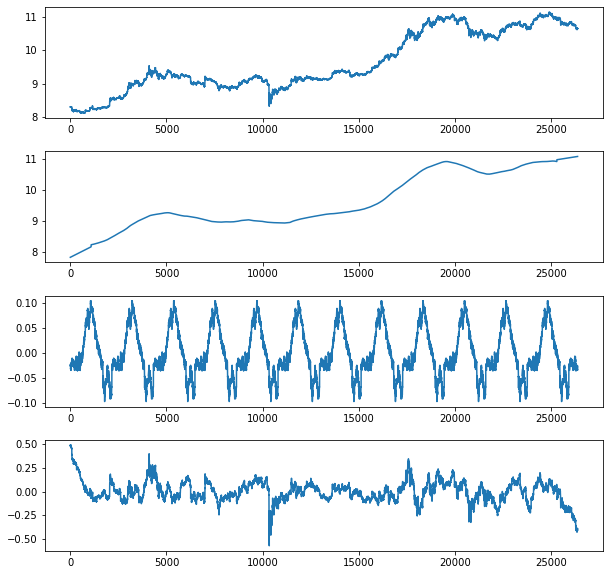

In [16]:
### 2. Bitcoin Price Y
bitcoin_price = bitcoin.close
log_bitcoin_price = np.log(bitcoin_price)
log_bit_decomp = additive_decompose(data = log_bitcoin_price)

In [17]:
### 3. Reshape
# log bitcoin (Y; non-overlapped)
log_bit_day = log_bitcoin_price.values.reshape(int(len(log_bitcoin_price)/24), 24)
print(log_bit_day.shape)

log_bit_week = log_bitcoin_price.values.reshape(int(len(log_bitcoin_price)/168), 168)
print(log_bit_week.shape)

# residuals (Y; non-overlapped)
resid_day = log_bit_decomp.resid.values.reshape(int(len(log_bit_decomp.resid)/24), 24)
print(resid_day.shape)

resid_week = log_bit_decomp.resid.values.reshape(int(len(log_bit_decomp.resid)/168), 168)
print(resid_week.shape)

# Inputs (X; non-overlapped)
all_inputs_norm_day = all_inputs_norm.reshape((all_inputs_norm.shape[0], 1, all_inputs_norm.shape[1]))
print(all_inputs_norm_day.shape)

all_inputs_norm_week = all_inputs_norm.reshape((int(all_inputs_norm.shape[0]/7), 7, all_inputs_norm.shape[1]))
print(all_inputs_norm_week.shape)

# Inputs (X; overlapped; two weeks -> one week)
weeks = 2
all_inputs_norm_week_lap = sliding_windows(pd.DataFrame(all_inputs_norm), n_out = 7*weeks-1)
all_inputs_norm_week_lap = all_inputs_norm_week_lap.values[[i for i in range(0, len(all_inputs_norm_week_lap), 7)], :]
all_inputs_norm_week_lap = all_inputs_norm_week_lap.reshape((len(all_inputs_norm_week_lap), 7*weeks, 8))
print(all_inputs_norm_week_lap.shape) # length is shorter compare to non-overlapped


(1099, 24)
(157, 168)
(1099, 24)
(157, 168)
(1099, 1, 8)
(157, 7, 8)
(156, 14, 8)


## Step 4: Specifiy the length for validating & testing lag and extract trend & seasonal 

In [18]:
# specify length
valid_week = 2
test_week = 1
total_week = valid_week + test_week
day_lag = 7
week_lag = 1

# extract trend & seasonal for validation and testing
trend = log_bit_decomp.trend.tail(7*3*24).values
seas = log_bit_decomp.seas.tail(7*3*24).values
real_val = log_bit_decomp.actual_values.tail(7*3*24).values

## Step 5: LSTM for regression (For model selecting)

### Model 3: X overlapped; 2 weeks to 1 week; Y uses residuals training

In [19]:
# data
data3_X = all_inputs_norm_week_lap
data3_Y = resid_week

# staggering
data3_X = data3_X[:-1]
data3_Y = data3_Y[2:]
print(data3_X.shape, data3_Y.shape)

# split training, validating, and testing
train3_X = data3_X[:-week_lag*total_week]; train3_Y = data3_Y[:-week_lag*total_week]
valid3_X = data3_X[(-week_lag*total_week):(-week_lag*test_week)]; valid3_Y = data3_Y[(-week_lag*total_week):(-week_lag*test_week)]
test3_X = data3_X[-week_lag*test_week:]; test3_Y = data3_Y[-week_lag*test_week:]
print(train3_X.shape, train3_Y.shape, valid3_X.shape, valid3_Y.shape, test3_X.shape, test3_Y.shape)


(155, 14, 8) (155, 168)
(152, 14, 8) (152, 168) (2, 14, 8) (2, 168) (1, 14, 8) (1, 168)


In [75]:
# design network
model3 = Sequential()
model3.add(Bidirectional(CuDNNLSTM(units = 300, return_sequences = True), input_shape=(train3_X.shape[1], train3_X.shape[2])))
model3.add(Bidirectional(CuDNNLSTM(units = 100, return_sequences = True)))
model3.add(GlobalAveragePooling1D())
model3.add(Dense(300, activation = 'sigmoid'))
model3.add(Dense(168))
model3.compile(loss='mse', metrics = ['mae'], optimizer='adam')

# fit network
model3.fit(train3_X, train3_Y, batch_size=50, epochs=200, validation_data=(valid3_X, valid3_Y), shuffle=False)

Epoch 1/200
4/4 [==============================] - 5s 1s/step - loss: 0.1727 - mae: 0.3192 - val_loss: 0.0631 - val_mae: 0.2071
Epoch 2/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0365 - mae: 0.1540 - val_loss: 0.0457 - val_mae: 0.1712
Epoch 3/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0408 - mae: 0.1646 - val_loss: 0.0502 - val_mae: 0.1840
Epoch 4/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0324 - mae: 0.1392 - val_loss: 0.0415 - val_mae: 0.1750
Epoch 5/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0207 - mae: 0.1116 - val_loss: 0.0318 - val_mae: 0.1541
Epoch 6/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0162 - mae: 0.1012 - val_loss: 0.0264 - val_mae: 0.1426
Epoch 7/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0152 - mae: 0.0978 - val_loss: 0.0235 - val_mae: 0.1342
Epoch 8/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0139 - mae: 0.0935

4/4 [==============================] - 0s 10ms/step - loss: 0.0060 - mae: 0.0604 - val_loss: 0.0176 - val_mae: 0.1224
Epoch 64/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0068 - mae: 0.0649 - val_loss: 0.0153 - val_mae: 0.1112
Epoch 65/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0065 - mae: 0.0630 - val_loss: 0.0189 - val_mae: 0.1269
Epoch 66/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0064 - mae: 0.0629 - val_loss: 0.0136 - val_mae: 0.1035
Epoch 67/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0058 - mae: 0.0585 - val_loss: 0.0179 - val_mae: 0.1226
Epoch 68/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0058 - mae: 0.0596 - val_loss: 0.0122 - val_mae: 0.0967
Epoch 69/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0055 - mae: 0.0569 - val_loss: 0.0187 - val_mae: 0.1254
Epoch 70/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0055 - mae: 0.0578 - 

4/4 [==============================] - 0s 11ms/step - loss: 0.0045 - mae: 0.0517 - val_loss: 0.0105 - val_mae: 0.0856
Epoch 126/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0042 - mae: 0.0499 - val_loss: 0.0151 - val_mae: 0.1065
Epoch 127/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0039 - mae: 0.0484 - val_loss: 0.0115 - val_mae: 0.0900
Epoch 128/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0037 - mae: 0.0474 - val_loss: 0.0103 - val_mae: 0.0851
Epoch 129/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0036 - mae: 0.0469 - val_loss: 0.0093 - val_mae: 0.0807
Epoch 130/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0035 - mae: 0.0454 - val_loss: 0.0084 - val_mae: 0.0767
Epoch 131/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0041 - mae: 0.0477 - val_loss: 0.0077 - val_mae: 0.0730
Epoch 132/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0039 - mae: 0.

4/4 [==============================] - 0s 10ms/step - loss: 0.0030 - mae: 0.0406 - val_loss: 0.0078 - val_mae: 0.0752
Epoch 188/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0026 - mae: 0.0393 - val_loss: 0.0046 - val_mae: 0.0556
Epoch 189/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0021 - mae: 0.0351 - val_loss: 0.0061 - val_mae: 0.0651
Epoch 190/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0022 - mae: 0.0359 - val_loss: 0.0039 - val_mae: 0.0517
Epoch 191/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0341 - val_loss: 0.0041 - val_mae: 0.0518
Epoch 192/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0339 - val_loss: 0.0054 - val_mae: 0.0611
Epoch 193/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0020 - mae: 0.0337 - val_loss: 0.0043 - val_mae: 0.0545
Epoch 194/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.

In [76]:
model3.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_36 (Bidirectio (None, 14, 600)           744000    
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 14, 200)           561600    
_________________________________________________________________
global_average_pooling1d_18  (None, 200)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 300)               60300     
_________________________________________________________________
dense_37 (Dense)             (None, 168)               50568     
Total params: 1,416,468
Trainable params: 1,416,468
Non-trainable params: 0
_________________________________________________________________


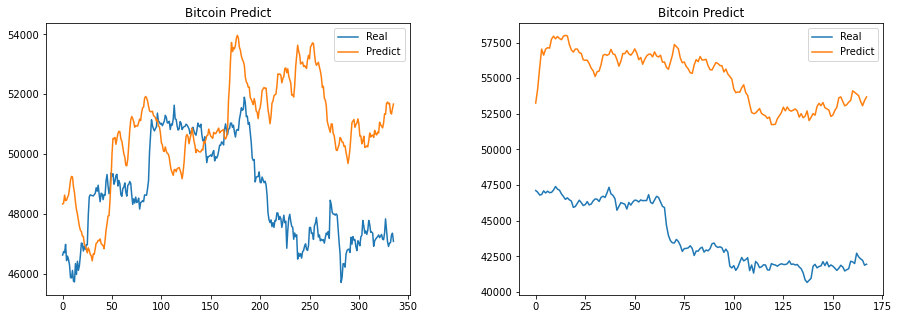

In [77]:
# Result for validation and testing
result3 = np.exp(np.concatenate((model3.predict(valid3_X).flatten(), 
                                 model3.predict(test3_X).flatten()), axis = 0) + trend + seas)

# smooth result
windows = 4
result3_smooth = pd.DataFrame(result3).rolling(window = windows).mean()
result3_smooth[0:windows-1] = pd.DataFrame(result3[0:windows-1])
result3_smooth = result3_smooth.values

plt.subplots(figsize = (15, 5))
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

# plot validation
plt.subplot(1, 2, 1)
plt.plot(np.exp(real_val[0:7*24*2]))
plt.plot(result3_smooth[0:7*24*2])
plt.title('Bitcoin Predict')
plt.legend(['Real', 'Predict'], loc='upper right')

# plot testing
plt.subplot(1, 2, 2)
plt.plot(np.exp(real_val[7*24*2:7*24*3]))
plt.plot(result3_smooth[7*24*2:7*24*3])
plt.title('Bitcoin Predict')
plt.legend(['Real', 'Predict'], loc='upper right')

## Step 6: LSTM for regression (For real testing)
- After you have selected the best model above, then you can do slight adjustment for the model (Under is the example using model 3)
- Note: Don't be too harsh to validation result, because there will be a suprise in real predicting

In [56]:
# data
real_predict_X = all_inputs_norm_week_lap
real_predict_Y = resid_week

# staggering
real_predict_X = real_predict_X[:-1]
real_predict_Y = real_predict_Y[2:]
print(real_predict_X.shape, real_predict_Y.shape)

# split training, validating, and testing
training_X = real_predict_X[:-1]; training_Y = real_predict_Y[:-1]
validation_X = real_predict_X[-1:]; validation_Y = real_predict_Y[-1:]
print(training_X.shape, training_Y.shape, validation_X.shape, validation_Y.shape)

(155, 14, 8) (155, 168)
(154, 14, 8) (154, 168) (1, 14, 8) (1, 168)


In [78]:
# design network
prediction = Sequential()
prediction.add(Bidirectional(CuDNNLSTM(units = 300, return_sequences = True), input_shape=(train3_X.shape[1], train3_X.shape[2])))
prediction.add(Bidirectional(CuDNNLSTM(units = 100, return_sequences = True)))
prediction.add(GlobalAveragePooling1D())
prediction.add(Dense(300, activation = 'sigmoid'))
prediction.add(Dense(168))
prediction.compile(loss='mse', metrics = ['mae'], optimizer='adam')

# fit network
prediction.fit(training_X, training_Y, batch_size=50, epochs=200, validation_data=(validation_X, validation_Y), shuffle=False)

Epoch 1/200
4/4 [==============================] - 8s 2s/step - loss: 0.2112 - mae: 0.3421 - val_loss: 0.1339 - val_mae: 0.3092
Epoch 2/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0447 - mae: 0.1693 - val_loss: 0.0989 - val_mae: 0.2803
Epoch 3/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0375 - mae: 0.1567 - val_loss: 0.1160 - val_mae: 0.3050
Epoch 4/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0370 - mae: 0.1474 - val_loss: 0.0968 - val_mae: 0.2870
Epoch 5/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0266 - mae: 0.1252 - val_loss: 0.0738 - val_mae: 0.2516
Epoch 6/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0190 - mae: 0.1084 - val_loss: 0.0692 - val_mae: 0.2488
Epoch 7/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0162 - mae: 0.1006 - val_loss: 0.0720 - val_mae: 0.2563
Epoch 8/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0146 - mae: 0.0965

4/4 [==============================] - 0s 10ms/step - loss: 0.0061 - mae: 0.0606 - val_loss: 0.0190 - val_mae: 0.1316
Epoch 64/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0066 - mae: 0.0632 - val_loss: 0.0117 - val_mae: 0.1011
Epoch 65/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0067 - mae: 0.0645 - val_loss: 0.0085 - val_mae: 0.0843
Epoch 66/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0097 - mae: 0.0764 - val_loss: 0.0159 - val_mae: 0.1197
Epoch 67/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0070 - mae: 0.0670 - val_loss: 0.0146 - val_mae: 0.1144
Epoch 68/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0067 - mae: 0.0642 - val_loss: 0.0093 - val_mae: 0.0886
Epoch 69/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0064 - mae: 0.0607 - val_loss: 0.0157 - val_mae: 0.1195
Epoch 70/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0062 - mae: 0.0621 - 

4/4 [==============================] - 0s 11ms/step - loss: 0.0030 - mae: 0.0414 - val_loss: 0.0107 - val_mae: 0.0973
Epoch 126/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0029 - mae: 0.0402 - val_loss: 0.0088 - val_mae: 0.0875
Epoch 127/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0028 - mae: 0.0393 - val_loss: 0.0113 - val_mae: 0.1016
Epoch 128/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0027 - mae: 0.0402 - val_loss: 0.0095 - val_mae: 0.0920
Epoch 129/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0028 - mae: 0.0395 - val_loss: 0.0118 - val_mae: 0.1033
Epoch 130/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0031 - mae: 0.0441 - val_loss: 0.0110 - val_mae: 0.0984
Epoch 131/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0034 - mae: 0.0445 - val_loss: 0.0120 - val_mae: 0.1053
Epoch 132/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0040 - mae: 0.

4/4 [==============================] - 0s 10ms/step - loss: 0.0027 - mae: 0.0389 - val_loss: 0.0151 - val_mae: 0.1165
Epoch 188/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0030 - mae: 0.0407 - val_loss: 0.0092 - val_mae: 0.0912
Epoch 189/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0025 - mae: 0.0362 - val_loss: 0.0140 - val_mae: 0.1126
Epoch 190/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0023 - mae: 0.0355 - val_loss: 0.0108 - val_mae: 0.0979
Epoch 191/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0023 - mae: 0.0343 - val_loss: 0.0105 - val_mae: 0.0961
Epoch 192/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0020 - mae: 0.0327 - val_loss: 0.0118 - val_mae: 0.1034
Epoch 193/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0020 - mae: 0.0327 - val_loss: 0.0111 - val_mae: 0.0998
Epoch 194/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0017 - mae: 0.

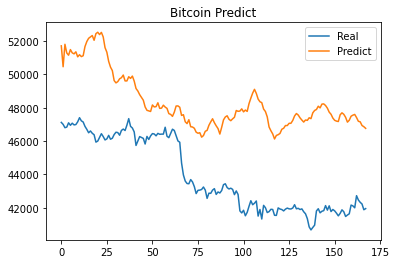

In [79]:
valid_trend = log_bit_decomp.trend.tail(7*1*24).values
valid_seas = log_bit_decomp.seas.tail(7*1*24).values
valid_real_val = log_bit_decomp.actual_values.tail(7*1*24).values

# Result for validation 
valid_result = np.exp(prediction.predict(validation_X).flatten() + valid_trend + valid_seas)

# smooth result
windows = 4
valid_smooth = pd.DataFrame(valid_result).rolling(window = windows).mean()
valid_smooth[0:windows-1] = pd.DataFrame(valid_result[0:windows-1])
valid_smooth = valid_smooth.values

# plot validation
plt.plot(np.exp(valid_real_val))
plt.plot(valid_smooth)
plt.title('Bitcoin Predict')
plt.legend(['Real', 'Predict'], loc='upper right')

未來一個禮拜價格最低可來到: 35132.42256017435
未來一個禮拜價格最高可來到: 41660.69


array([[41660.69      ],
       [40182.48742322],
       [41431.90798178],
       [40947.52966265],
       [40692.45777237],
       [40967.99971978],
       [40715.47602574],
       [40683.19594095],
       [40784.13771547],
       [40337.13709656],
       [40288.03013737],
       [40004.78079953],
       [39891.42417621],
       [40230.26983313],
       [40371.02930479],
       [40337.09307013],
       [40171.06992572],
       [40137.68710854],
       [39774.23306527],
       [40219.23938305],
       [40384.14632367],
       [40321.50533044],
       [40504.51512425],
       [40220.2111993 ],
       [39538.69190826],
       [39259.61147079],
       [38662.34355501],
       [38263.01742334],
       [38054.8049019 ],
       [37467.10686003],
       [37377.02876286],
       [37514.78962424],
       [37644.83625176],
       [37654.88466136],
       [37756.95757118],
       [37302.71744239],
       [37270.88068329],
       [37496.97282171],
       [37385.12128178],
       [37539.59587458],


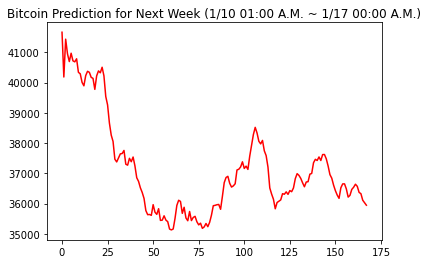

In [80]:
# Here you can get the output for the real future bitcoin price prediction using Predict_for_Teacher function (Not run)
# Note that data size is correct
# Check if the first prediction is suitable
data = data3_X[-1].reshape(1, 14, 8)
Predict = prediction(data)
Predict_for_Teacher(predict = Predict, peek_price = 41660.69, shift = True)

## Step 7: Classification

### Clustering for classification label

In [81]:
# Combine new predicted data to do ICA together
ica_data = np.concatenate((resid_week.T, np.array(Predict).T), axis = 1)

# ICA decomposition
ica = FastICA(n_components = 7, max_iter = 100000, random_state = 2021)
ica_result = ica.fit_transform(ica_data)

Text(0, 0.5, 'Fuzzy partition coefficient')

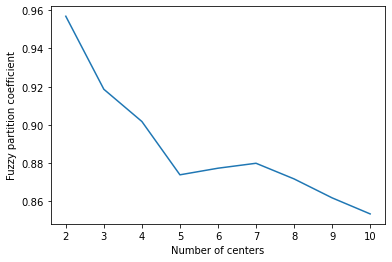

In [82]:
# Leave predicted data's ica mixing
cmeans_train = ica.mixing_.T[:, 0:ica.mixing_.shape[0]-1]
cmeans_predict = ica.mixing_.T[:, ica.mixing_.shape[0]-1]

# Cmeans for validation
fpcs = []

for i in range(2, 11, 1):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        cmeans_train, i, 1.2, error = 0.005, maxiter = 1000, seed = 2021)

    # Store fpc values for later
    fpcs.append(fpc)
    
fig, ax = plt.subplots()
ax.plot(np.r_[2:11], fpcs)
ax.set_xlabel("Number of centers")
ax.set_ylabel("Fuzzy partition coefficient")

In [83]:
# Train Cmeans
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(cmeans_train, c = 5, m = 1.2, error=0.005, maxiter = 1000, seed = 2021)

# Count numbers for each group
cmeans_label = u.argmax(axis = 0)
unique, counts = np.unique(cmeans_label, return_counts = True)
dict(zip(unique, counts))

{0: 31, 1: 35, 2: 21, 3: 15, 4: 55}

### Neural network for classification

In [84]:
# data (ICA coefficients)
X = cmeans_train.T
Y = to_categorical(cmeans_label)

# train & test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2021)

In [87]:
# model
classification = Sequential()
classification.add(Dense(input_dim = X_train.shape[1], units = 15, activation = 'relu'))
classification.add(Dense(units = 8, activation = 'relu'))
classification.add(Dense(units = Y_train.shape[1], activation = 'softmax'))

# model compile
classification.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fit
classification.fit(X_train, Y_train, batch_size = 35, epochs = 120, validation_data=(X_test, Y_test))

Epoch 1/120
4/4 [==============================] - 0s 22ms/step - loss: 1.6048 - accuracy: 0.1840 - val_loss: 1.6002 - val_accuracy: 0.2500
Epoch 2/120
4/4 [==============================] - 0s 4ms/step - loss: 1.5997 - accuracy: 0.2240 - val_loss: 1.5952 - val_accuracy: 0.3125
Epoch 3/120
4/4 [==============================] - 0s 4ms/step - loss: 1.5948 - accuracy: 0.2880 - val_loss: 1.5903 - val_accuracy: 0.3438
Epoch 4/120
4/4 [==============================] - 0s 4ms/step - loss: 1.5898 - accuracy: 0.3600 - val_loss: 1.5859 - val_accuracy: 0.3750
Epoch 5/120
4/4 [==============================] - 0s 4ms/step - loss: 1.5844 - accuracy: 0.3920 - val_loss: 1.5816 - val_accuracy: 0.4062
Epoch 6/120
4/4 [==============================] - 0s 4ms/step - loss: 1.5791 - accuracy: 0.4400 - val_loss: 1.5776 - val_accuracy: 0.4062
Epoch 7/120
4/4 [==============================] - 0s 4ms/step - loss: 1.5733 - accuracy: 0.4720 - val_loss: 1.5729 - val_accuracy: 0.4375
Epoch 8/120
4/4 [=========

4/4 [==============================] - 0s 4ms/step - loss: 0.9611 - accuracy: 0.8160 - val_loss: 0.9886 - val_accuracy: 0.8750
Epoch 60/120
4/4 [==============================] - 0s 4ms/step - loss: 0.9475 - accuracy: 0.8160 - val_loss: 0.9758 - val_accuracy: 0.8750
Epoch 61/120
4/4 [==============================] - 0s 4ms/step - loss: 0.9340 - accuracy: 0.8240 - val_loss: 0.9629 - val_accuracy: 0.8750
Epoch 62/120
4/4 [==============================] - 0s 4ms/step - loss: 0.9210 - accuracy: 0.8400 - val_loss: 0.9493 - val_accuracy: 0.8750
Epoch 63/120
4/4 [==============================] - 0s 4ms/step - loss: 0.9080 - accuracy: 0.8320 - val_loss: 0.9364 - val_accuracy: 0.8750
Epoch 64/120
4/4 [==============================] - 0s 4ms/step - loss: 0.8949 - accuracy: 0.8400 - val_loss: 0.9250 - val_accuracy: 0.8750
Epoch 65/120
4/4 [==============================] - 0s 4ms/step - loss: 0.8821 - accuracy: 0.8560 - val_loss: 0.9140 - val_accuracy: 0.8750
Epoch 66/120
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.4694 - accuracy: 0.8880 - val_loss: 0.5502 - val_accuracy: 0.8750
Epoch 118/120
4/4 [==============================] - 0s 4ms/step - loss: 0.4644 - accuracy: 0.8960 - val_loss: 0.5446 - val_accuracy: 0.8750
Epoch 119/120
4/4 [==============================] - 0s 4ms/step - loss: 0.4596 - accuracy: 0.8960 - val_loss: 0.5394 - val_accuracy: 0.8750
Epoch 120/120
4/4 [==============================] - 0s 4ms/step - loss: 0.4548 - accuracy: 0.8960 - val_loss: 0.5343 - val_accuracy: 0.8750


In [88]:
# model predict 
cmeans_predict = cmeans_predict.reshape(1, X_train.shape[1])
int(classification.predict(cmeans_predict).argmax(axis = 1).flatten())

1

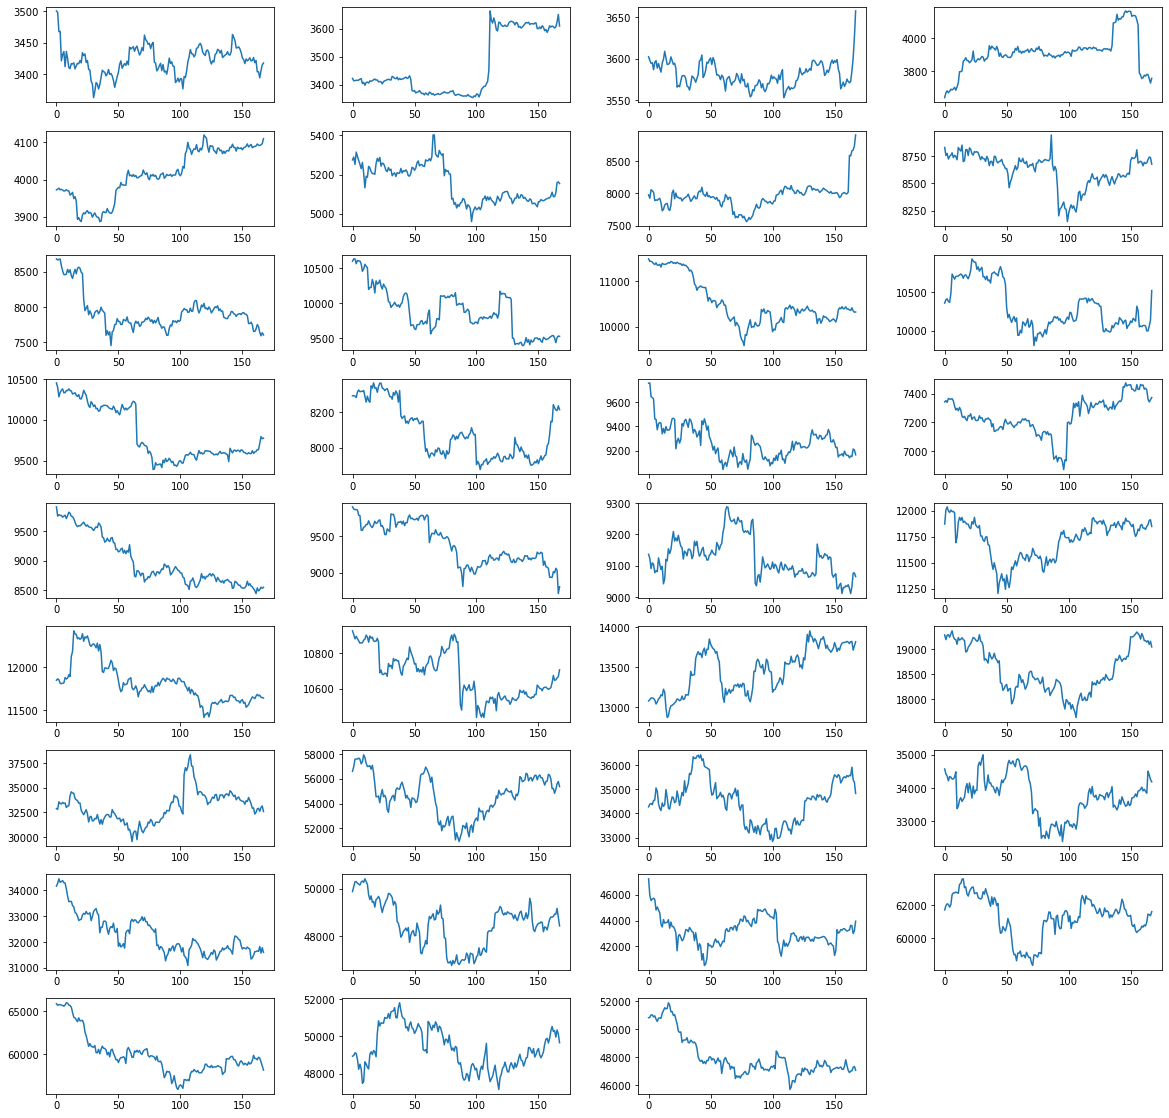

In [96]:
# reshape origin bitcoin price
Bit = bitcoin_price.values.reshape(int(len(bitcoin_price)/168), 168)

# plot the group which predicted data belongs to
a = [i for i, x in enumerate(cmeans_label) if x == 1]

count = 1
plt.subplots(figsize = (20, 20))
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
for i in range(35):
    plt.subplot(9, 4, count)
    plt.plot(Bit[a[count-1],:].T)
    count+=1

plt.show()